In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai import *
from fastai.vision import *

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import time

In [26]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [27]:
from fastai.vision import *
from fastai.metrics import error_rate

In [28]:
def plot_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    
    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()



In [29]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def get_filename(path):
    absolute_fname = path.as_posix()
    absolute_fname_parts = absolute_fname.split('/')
    fname = absolute_fname_parts[len(absolute_fname_parts) - 1]
    return fname

def save_spectrogram(audio_fname, image_fname):
    y, sr = librosa.load(audio_fname, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    fig1 = plt.gcf()
    plt.axis('off')
    plt.show()
    plt.draw()
    fig1.savefig(image_fname, dpi=100)

def audio_to_spectrogram(audio_dir_path, image_dir_path=None):
    for paths in batch(audio_dir_path.ls(), 100):
        for audio_path in paths:
            audio_filename = get_filename(audio_path)
            image_fname = audio_filename.split('.')[0] + '.png'
            if image_dir_path:
                image_fname = image_dir_path.as_posix() + '/' + image_fname
            if Path(image_fname).exists(): continue
            print(image_fname)
            #plot_spectrogram(image_fname)
            try:
                save_spectrogram(audio_path.as_posix(), image_fname)
            except ValueError as verr:
                print('Failed to process %s %s' % (image_fname, verr))
        # wait between every batch for xyz seconds
        time.sleep(1)



In [30]:
path = Path('G:\data\FSDKaggle')

In [31]:
df_train = pd.read_csv(path/'FSDKaggle2019.meta'/'train_curated_post_competition.csv')
df_train = df_train.drop(columns =  ['license', 'freesound_id'])
df_train.head()

,fname,labels
0,ac9e7a91.wav,Church_bell
1,65ae847e.wav,Frying_(food)
2,32ec2454.wav,Computer_keyboard
3,af7b5bab.wav,Scissors
4,7e8cd849.wav,Purr


In [32]:
labels = df_train['labels']

In [33]:
#audio_to_spectrogram(path/'FSDKaggle2019.audio_train_curated', path/'image_train')

In [34]:
#audio_to_spectrogram(path/'FSDKaggle2019.audio_train_noisy', path/'image_train_noisy')

In [35]:
#audio_to_spectrogram(path/'FSDKaggle2019.audio_test', path/'image_test')

In [36]:
df_train['fname'] = df_train['fname'].str[:-4]

In [37]:
df_train.head()

,fname,labels
0,ac9e7a91,Church_bell
1,65ae847e,Frying_(food)
2,32ec2454,Computer_keyboard
3,af7b5bab,Scissors
4,7e8cd849,Purr


In [38]:
df_classes = pd.read_csv(path/'FSDKaggle2019.meta'/'vocabulary.csv')

In [39]:
classes = df_classes['classes'].to_list()

In [40]:
np.random.seed(42)
src = (ImageList.from_df(df_train,path, folder='image_train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',',classes=classes))


In [41]:
tfms = get_transforms(do_flip=False, p_affine=0, p_lighting=0)
data = src.transform(tfms, size=(224,336)).databunch(bs=32).normalize(imagenet_stats)

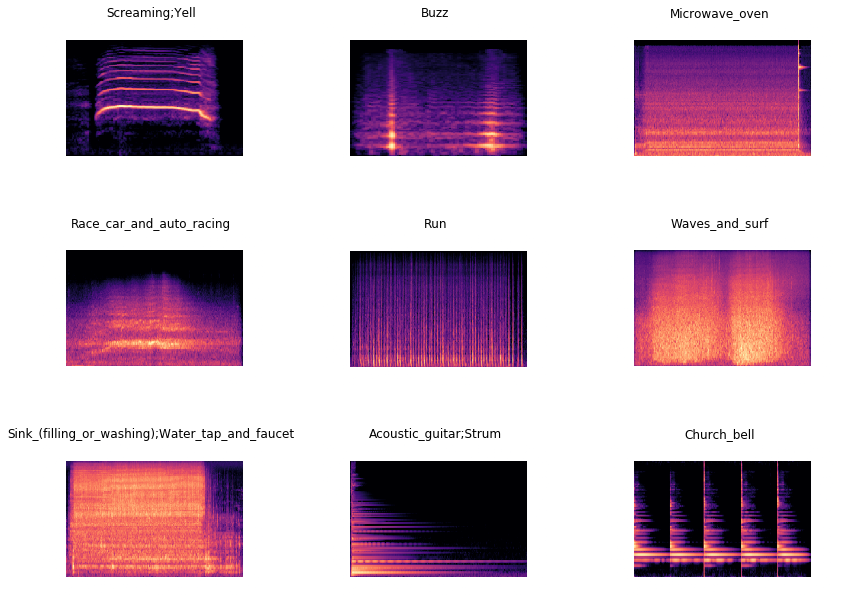

In [42]:
data.show_batch(rows=3, figsize=(12,9))

In [43]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

In [48]:
arch = models.resnet34

In [49]:
learn = cnn_learner(data, arch, metrics=[lwlrap])

In [50]:
#learn.lr_find()

In [51]:
#learn.recorder.plot()

In [54]:
lr = 0.02

In [55]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,lwlrap,time
0,0.232946,0.060009,0.434234,01:14
1,0.075964,0.050143,0.540548,01:10
2,0.050242,0.041682,0.636043,01:13
3,0.037986,0.036159,0.697150,01:11
4,0.029376,0.034840,0.721140,01:11


In [56]:
learn.save('stage-1-curated')

In [57]:
learn.unfreeze()

In [58]:
#learn.lr_find()
#learn.recorder.plot()

In [59]:
learn.fit_one_cycle(5, slice(8e-6, 5e-04))

epoch,train_loss,valid_loss,lwlrap,time
0,0.027771,0.034386,0.721511,01:30
1,0.027190,0.031743,0.739849,01:22
2,0.020702,0.030244,0.758236,01:22
3,0.014536,0.029531,0.771918,01:25
4,0.011443,0.029213,0.776940,01:25


In [60]:
learn.save('stage-2-curated')

In [61]:
#learn.recorder.plot_losses()

In [62]:
df_train = pd.read_csv(path/'FSDKaggle2019.meta'/'train_noisy_post_competition.csv')
df_train = df_train.drop(columns =  ['license', 'flickr_video_URL'])
df_train.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [63]:
labels = df_train['labels']

In [64]:
df_train['fname'] = df_train['fname'].str[:-4]
df_train.head()

,fname,labels
0,00097e21,Bathtub_(filling_or_washing)
1,000b6cfb,Motorcycle
2,00116cd2,"Marimba_and_xylophone,Glockenspiel"
3,00127d14,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae,Raindrop


In [65]:
src = (ImageList.from_df(df_train,path, folder='image_train_noisy', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',',classes=classes))

In [66]:
tfms = get_transforms(do_flip=False, p_affine=0, p_lighting=0)
data = src.transform(tfms, size=(224,336)).databunch(bs=32).normalize(imagenet_stats)

In [67]:
learn = cnn_learner(data, arch, metrics=[lwlrap])

In [68]:
learn.load('stage-2-curated')

Learner(data=ImageDataBunch;

Train: LabelList (15852 items)
x: ImageList
Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336)
y: MultiCategoryList
Bathtub_(filling_or_washing),Motorcycle,Marimba_and_xylophone;Glockenspiel,Water_tap_and_faucet;Sink_(filling_or_washing),Raindrop
Path: G:\data\FSDKaggle;

Valid: LabelList (3963 items)
x: ImageList
Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336)
y: MultiCategoryList
Zipper_(clothing),Purr,Microwave_oven,Cricket,Female_singing
Path: G:\data\FSDKaggle;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): 

In [69]:
#learn.lr_find()
#learn.recorder.plot()

In [70]:
lr=1e-2

In [71]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,lwlrap,time
0,0.062218,0.057356,0.406659,02:12
1,0.058668,0.053775,0.462999,02:09
2,0.054291,0.050303,0.506988,02:06
3,0.049823,0.048487,0.523768,02:06
4,0.045841,0.048090,0.532691,02:06


In [72]:
#learn.recorder.plot_losses()

In [73]:
learn.save('stage-1-noisy')

In [74]:
learn.unfreeze()

In [75]:
#learn.lr_find()
#learn.recorder.plot()

In [76]:
learn.fit_one_cycle(5, slice(1e-6, 5e-6))

epoch,train_loss,valid_loss,lwlrap,time
0,0.045803,0.048024,0.532151,03:43
1,0.045100,0.047744,0.537789,03:42
2,0.044324,0.047549,0.539705,04:23
3,0.043140,0.047553,0.539688,04:57
4,0.044291,0.047571,0.538075,04:22


In [77]:
learn.save('stage-2-noisy')

In [78]:
df_train = pd.read_csv(path/'FSDKaggle2019.meta'/'train_curated_post_competition.csv')
df_train = df_train.drop(columns =  ['license', 'freesound_id'])
df_train['fname'] = df_train['fname'].str[:-4]
src = (ImageList.from_df(df_train,path, folder='image_train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',',classes=classes))
tfms = get_transforms(do_flip=False, p_affine=0, p_lighting=0)
data = src.transform(tfms, size=(224,336)).databunch(bs=32).normalize(imagenet_stats)
learn = cnn_learner(data, arch, metrics=[lwlrap])
learn.load('stage-2-noisy')

Learner(data=ImageDataBunch;

Train: LabelList (3972 items)
x: ImageList
Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336)
y: MultiCategoryList
Church_bell,Scissors,Gasp,Applause;Cheering,Applause;Crowd;Cheering
Path: G:\data\FSDKaggle;

Valid: LabelList (992 items)
x: ImageList
Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336)
y: MultiCategoryList
Frying_(food),Child_speech_and_kid_speaking,Stream,Sigh,Traffic_noise_and_roadway_noise
Path: G:\data\FSDKaggle;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), str

In [79]:
learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot()

In [80]:
lr = 2e-05
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,lwlrap,time
0,0.064572,0.058328,0.411524,03:03
1,0.059988,0.051958,0.489854,03:41
2,0.055017,0.048573,0.534046,03:05
3,0.051848,0.047338,0.546750,03:06
4,0.051295,0.047300,0.551882,02:33


In [81]:
lr = 1e-06
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,lwlrap,time
0,0.050596,0.047138,0.545890,03:06
1,0.050838,0.047077,0.548033,03:03
2,0.050884,0.046910,0.550697,02:29
3,0.050162,0.046854,0.550129,02:40
4,0.050337,0.046775,0.551165,02:44


In [82]:
learn.save('stage-3-mixed')

In [83]:
#learn.recorder.plot_losses()

In [84]:
#learn.lr_find()
#learn.recorder.plot()

In [85]:
learn.fit_one_cycle(5, slice(1e-06, 2e-04))

epoch,train_loss,valid_loss,lwlrap,time
0,0.048147,0.042459,0.602198,03:40
1,0.040934,0.036442,0.688979,03:33
2,0.034293,0.033115,0.729271,03:09
3,0.030726,0.032096,0.737723,03:09
4,0.029418,0.031949,0.738990,03:05


In [86]:
learn.save('stage-4-mixed')

## PREDICT/TEST

In [87]:
df_test = pd.read_csv(path/'FSDKaggle2019.meta'/'test_post_competition.csv')
df_test = df_test.drop(columns =  ['license', 'freesound_id', 'usage'])
df_test['fname'] = df_test['fname'].str[:-4]
# test = ImageList.from_df(df_test,path, folder='image_test', suffix='.png')
# #test_data = src.transform(tfms, size=(224,336)).databunch(bs=32).normalize(imagenet_stats)
# data.add_test(test)
# df_test['fname'] = 'image_test\\' + df_test['fname'].astype(str)
# df = pd.concat([df_train,df_test])

# df.head()

In [88]:
tfms = get_transforms(do_flip=False, p_affine=0, p_lighting=0)
data_test = (ImageList.from_df(df_test,path, folder='image_test', suffix='.png')
        .split_by_rand_pct(1.0)
        .label_from_df(label_delim=',',classes=classes)
        .transform(tfms, size=(224,336))
        .databunch(bs=32)
        .normalize(imagenet_stats)
       ) 

C:\Users\Madis\Anaconda3\envs\fastai\lib\site-packages\fastai\data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [89]:
arch = models.resnet34
learn = cnn_learner(data_test, arch, metrics=[lwlrap])
learn.load('stage-4-mixed')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: G:\data\FSDKaggle;

Valid: LabelList (4481 items)
x: ImageList
Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336),Image (3, 224, 336)
y: MultiCategoryList
Yell,Chirp_and_tweet;Cricket,Zipper_(clothing),Dishes_and_pots_and_pans;Chink_and_clink,Sink_(filling_or_washing);Water_tap_and_faucet
Path: G:\data\FSDKaggle;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [90]:
learn.validate(data_test.valid_dl)

[0.056506045, tensor(0.5545)]

In [91]:
learn.export()